# Text data (20newsgroups) Preprocess

test

In [1]:


#
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



from sklearn.datasets import fetch_20newsgroups

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support


from sklearn.feature_extraction.text import TfidfVectorizer
# from time import time

from time import time


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

## fit and evaluate the clustering

from collections import defaultdict
# from time import time


import collections
import pickle


# define ENV



## RL functions##
import random
from collections import deque

import math


In [2]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


# Load the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=categories,)

# Create a DataFrame from the dataset
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})

# Map target labels to target names
df['label'] = df['label'].map(lambda x: newsgroups.target_names[x])

true_k = len(df.label.unique())
labels = df['label']

print(f"Number of unique labels: {true_k}")

# Explore the dataset
print(df.head())
print(df['label'].value_counts())


Number of unique labels: 4
                                                text               label
0  My point is that you set up your views as the ...         alt.atheism
1  \nBy '8 grey level images' you mean 8 items of...       comp.graphics
2  FIRST ANNUAL PHIGS USER GROUP CONFERENCE\n\n  ...       comp.graphics
3  I responded to Jim's other articles today, but...  talk.religion.misc
4  \nWell, I am placing a file at my ftp today th...       comp.graphics
label
sci.space             987
comp.graphics         973
alt.atheism           799
talk.religion.misc    628
Name: count, dtype: int64


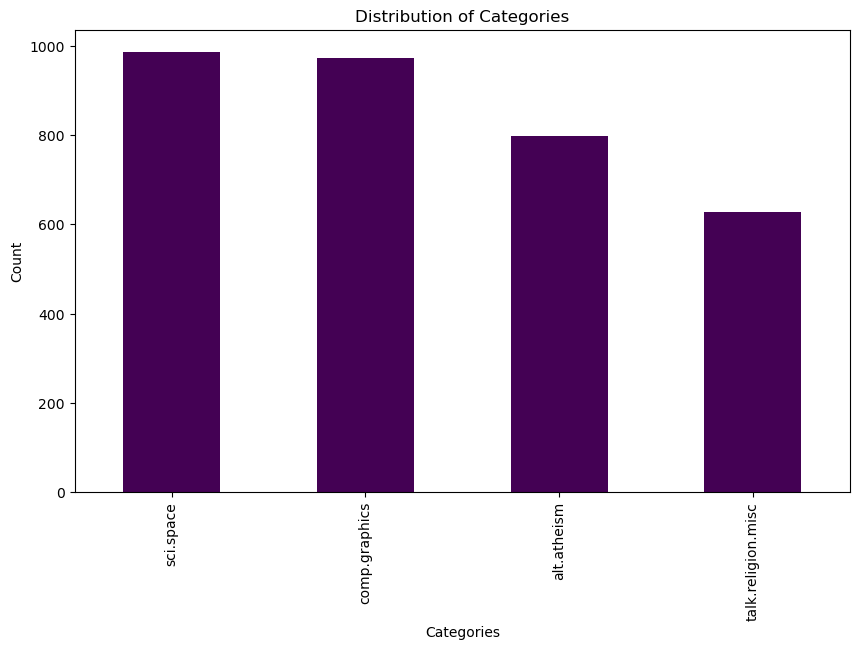

In [3]:
# Visualize the distribution of categories
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', colormap='viridis')
plt.title('Distribution of Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

## Vectorize - TFIDF


In [4]:


vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(df.text)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.386 s
n_samples: 3387, n_features: 7929


After ignoring terms that appear in more than 50% of the documents (as set by max_df=0.5) and terms that are not present in at least 5 documents (set by min_df=5), the resulting number of unique terms n_features is around 8,000. We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries divided by the total number of elements.

In [5]:


print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.007


We find that around 0.7% of the entries of the X_tfidf matrix are non-zero.

In [6]:


evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

## Performing dimensionality reduction using LSA
A n_init=1 can still be used as long as the dimension of the vectorized space is reduced first to make k-means more stable. For such purpose we use TruncatedSVD, which works on term count/tf-idf matrices. Since SVD results are not normalized, we redo the normalization to improve the KMeans result. Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis (LSA) in the information retrieval and text mining literature.

In [7]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.352 s
Explained variance of the SVD step: 18.4%


In [8]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.05 ± 0.04 s 
Homogeneity: 0.404 ± 0.007
Completeness: 0.427 ± 0.019
V-measure: 0.415 ± 0.012
Adjusted Rand-Index: 0.322 ± 0.023
Silhouette Coefficient: 0.029 ± 0.001


## Top terms per cluster
Since TfidfVectorizer can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster. See the example script Classification of text documents using sparse features for a comparison with the most predictive words for each target class.

In [9]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: think don just people like know moral say right good 
Cluster 1: space launch orbit shuttle nasa earth like moon mission satellite 
Cluster 2: god jesus does did say christian said time religion bible 
Cluster 3: thanks graphics image program know files file looking software ftp 


# Data prepare for RLCO

In [10]:
## check the data shape for RLCO
print(f"X_lsa_shape: {X_lsa.shape}")

print(f"X_lsa example:\n{X_lsa[0]}")

# print the type of X_lsa
print(f"X_lsa dtype: {type(X_lsa)}")

X_lsa_shape: (3387, 100)
X_lsa example:
[ 0.37924438  0.17122127 -0.07187948 -0.09206871  0.0294709   0.02314973
  0.02512366 -0.04919221  0.10649887  0.2206451  -0.27705728 -0.01772162
  0.00062832  0.01625666 -0.02507672  0.04203496 -0.03111452 -0.01657617
  0.01443506 -0.05072561 -0.10599808 -0.05889448 -0.04502196 -0.10542399
  0.15776778 -0.0936111  -0.10779433  0.11740034 -0.11294972  0.13213722
  0.06349596  0.01480145 -0.04811644 -0.03081459  0.06080247 -0.06282326
 -0.02111596  0.02649321  0.17215257 -0.0424962   0.16943338 -0.12840773
  0.01136576  0.01215554 -0.17181435 -0.05483488 -0.13209496 -0.0290776
 -0.03758376  0.06168886  0.02867876 -0.0079294   0.18539128 -0.08497528
  0.15169946  0.0814903   0.04347266 -0.11973982 -0.01974591  0.04974501
  0.00244395  0.14408466  0.03444394  0.05904236  0.03231306 -0.01514438
 -0.03016562  0.05142768  0.12571198 -0.03635647  0.01882475  0.16326982
  0.14105718  0.01790978 -0.09263432 -0.05830915 -0.03804782 -0.04593049
  0.07374049

In [11]:
## Check y shape and example:
y_int = df['label'].map(lambda x: newsgroups.target_names.index(x))
y_int = np.array(y_int)

print(f"y_int shape: {y_int.shape}")

print(f"first 10 y_int example:\n{y_int[0:10,]}")

# print the type of y_int
print(f"y_int dtype: {type(y_int)}")

y_int shape: (3387,)
first 10 y_int example:
[0 1 1 3 1 1 2 2 2 0]
y_int dtype: <class 'numpy.ndarray'>


In [12]:
# split the training(labeled) as 10% of dataset
X_l, X_ul, y_l, y_ul = train_test_split(X_lsa, y_int, test_size=0.8, random_state=0)


# split the training(labeled) as 50% of  labeled dataset
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.5, random_state=0)


In [13]:

# Initialize classifiers (KNN and SVM)
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
svm = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)
classifiers = [knn, svm]

In [14]:


class Env():
    def __init__(self, classifier_1, classifier_2, input_ul_data, k, X_test, y_test, X_reset, y_reset):
        # super().__init__
        self.model_1 = classifier_1
        self.model_2 = classifier_2
        # UN LABEL DATA
        self.X_ul = input_ul_data
        # define the evaluate data, later use for the reward
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        # cluster the data
        self.action_size = k
        self.kmeans = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label = self.kmeans.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = self.kmeans.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    # def cluster_plot(self):
    #     for i in self.u_cluster_label:
    #         plt.scatter(self.X_ul[self.cluster_label == i , 0] ,
    #                     self.X_ul[self.cluster_label == i , 1] ,
    #                     label = i)
    #     plt.scatter(self.centroids[:,0],
    #                 self.centroids[:,1],
    #                 s=80,
    #                 color='k')
    #     # plt.legend()
    #     plt.title(f'{self.k} cluster (centroids) of unlabeled data')
    #     plt.show()

    # update 2 clf
    def train_2_clf(self, X, y):
        self.model_1.fit(X, y)
        self.model_2.fit(X, y)

    def get_state(self,reset=False):
        np.random.seed(123)
        if reset:
            self.train_2_clf(self.X_reset, self.y_reset)
            print("reset")
        out_1 = self.model_1.predict_proba(self.centroids)
        out_2 = self.model_2.predict_proba(self.centroids)
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return  torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)


    # def get_acc(self):
    #     pred_1 = self.model_1.predict(self.X_eval)
    #     pred_2 = self.model_1.predict(self.X_eval)
    #     acc_1 = accuracy_score(pred_1, self.y_eval)
    #     acc_2 = accuracy_score(pred_2, self.y_eval)
    #     return acc_1, acc_2
    def get_f1(self):
        classifier_weights = [clf.score(self.X_eval, self.y_eval) for clf in [self.model_1, self.model_2]]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [clf.predict_proba(self.X_eval) for clf in [self.model_1, self.model_2]],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)


        # Calculate F1 scores per class (harmonic means)
        precision, recall, f1_per_class, _ = precision_recall_fscore_support(self.y_eval, combined_predictions, average=None)

        # Compute Macro-F1 as arithmetic mean of F1 scores
        macro_f1 = np.mean(f1_per_class)

        return macro_f1

    # def get_acc(self):
    #     pred_1 = self.model_1.predict(self.X_eval)
    #     pred_2 = self.model_1.predict(self.X_eval)
    #     acc_1 = accuracy_score(pred_1, self.y_eval)
    #     acc_2 = accuracy_score(pred_2, self.y_eval)
    #     return acc_1, acc_2

    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset = self.X_ul[self.cluster_label == action]
        return subset

    def co_training(self, subset):
        ## get posodu label
        clf_0_p_label = self.model_1.predict(subset)
        clf_1_p_label = self.model_2.predict(subset)

        ## get proba_
        clf_0_p_y = self.model_1.predict_proba(subset)
        clf_1_p_y = self.model_2.predict_proba(subset)

        #get the label size
        y_num = subset.shape[0]
        # set empty y  #type=ndarray
        y_ul_action = np.zeros(y_num,)

        #############
        # confidence_diff = 0
        # combine the lable from two classifier, choose the most conffidence
        for i in range(y_num):
            if max(clf_0_p_y[i, ]) > max(clf_1_p_y[i, ]):
                y_ul_action[i] = clf_0_p_label[i]
                # print('0')
            else:
                y_ul_action[i] = clf_1_p_label[i]
                # print('1')

        ########### update the label_set for traning
        X_updated = np.concatenate((X_l_train, subset), axis=0)
        y_updated = np.concatenate((y_l_train, y_ul_action), axis=0)

        # print(f'X shape is {X_updated.shape} \ny shape is {y_updated.shape}')

        ############# use the updated labeld dateset retrain those 2 classifier
        self.train_2_clf(X_updated, y_updated)

        # RETURN THE co-trained CLASSIFIER'S mean marcof1.
        marco_f1 = self.get_f1()
        return marco_f1

    def step(self, action):
        # GET THE bigining state accuracy, later use to calculate the reward
        pre_marco_f1 = self.get_f1()

        # choose subset
        choosen_subset =  self.get_subset(action)

        # cotraining the 2 classifier
        new_marco_f1 = self.co_training(choosen_subset)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        if new_marco_f1 > pre_marco_f1:
            reward_0 = new_marco_f1 - pre_marco_f1
        else:
            reward_0 = 0

        return n_state, reward_0, new_marco_f1


In [15]:





# Define the Q-network (a simple feedforward neural network)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class ReplayBuffer:

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state):
        # # bug - some times the state is not
        # if len(state) != 4:
        #     state = state[0]
        experience_tuple = (state, action, reward, next_state)
        # Append experience_tuple to the memory buffer
        self.memory.append(experience_tuple)

    def __len__(self):
        return len(self.memory)

    def sample(self, batch_size):
        # Draw a random sample of size batch_size
        batch = random.sample(self.memory, batch_size)
        # Transform batch into a tuple of lists
        states, actions, rewards, next_states = (zip(*batch))
        return states, actions, rewards, next_states



In [16]:
k = 20
env = Env(classifiers[0], classifiers[1], input_ul_data=X_ul, k=k, X_test=X_l_test, y_test=y_l_test, X_reset=X_l_train, y_reset=y_l_train)
state_0 = env.get_state(reset=True)
# print(f'state_0 shape is {state_0.shape} state_0:{state_0}')
state, reward, marco_f1 = env.step(19)
# print(f'state shape is {state.shape} state:{state} reward:{reward} marco_f1:{marco_f1}')


reset
reset


In [17]:
# import math
# 
#
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 1000
steps_done = 0

####
buffer_size = 10000
###
episodes = 500
max_step = 100
batch_size = 64
TAU = 0.005
gamma = 0.99

# hyper parameter
observation_size = env.observation_size
action_size = env.action_size
lr = 1e-4

###
# Initialize networks and optimizer
q_network = QNetwork(observation_size, action_size)
target_network = QNetwork(observation_size, action_size)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=lr)
loss_fn = nn.MSELoss()


# Replay memory
replay_buffer = ReplayBuffer(buffer_size)


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = torch.argmax(q_network(state)).item()
            return action
    else:
        return np.random.choice(range(k))

In [18]:
# Function to update the Q-network
def train():
    if len(replay_buffer) < batch_size:
        return
        # prepare the training data
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)

    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    actions = torch.tensor(np.array(actions)).unsqueeze(1)
    states = torch.tensor(np.array(states)).squeeze(1)
    next_states = torch.tensor(np.array(next_states)).squeeze(1)

    # # Compute current Q values
    q_values = q_network(states).gather(1, actions)



        # Compute target Q values
    with torch.no_grad():
        next_q_values = target_network(next_states).max(1).values.unsqueeze(1)
    targets = rewards + (gamma * next_q_values)


        # Update the network
    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss



In [19]:
#training loop
results = []
for episode in range(episodes):
    state = env.get_state(reset=True)
    total_reward = 0

    for t in range(max_step):
        action = select_action(state)
        observation, reward, marco_f1 = env.step(action)
# '''
#         done = terminated or truncated
#         if terminated:
#             next_state = None
#         else:
#             next_state = observation
# '''
        next_state = observation


        replay_buffer.push(state, action, reward, next_state)

        state = next_state
        total_reward += reward

        train()


        # Soft update of the target network's weights
        target_net_state_dict = q_network.state_dict()
        policy_net_state_dict = target_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_network.load_state_dict(target_net_state_dict)

        # if terminated or truncated:
        #     break


    results.append((episode, total_reward, marco_f1))
    print(f"Episode: {episode}, marco_f1: {marco_f1}, Total Reward: {total_reward}")

    # # ## for debug - train() - just get some replay memory.
    # if episode == 3:
    #     print('break')
    #     break

reset
Episode: 0, marco_f1: 0.6781986811679994, Total Reward: 0.03550394709257909
reset
Episode: 1, marco_f1: 0.6781986811679994, Total Reward: 0.18375264863485485
reset
Episode: 2, marco_f1: 0.6781986811679994, Total Reward: 0.16215941796119948
reset
Episode: 3, marco_f1: 0.6781986811679994, Total Reward: 0.2594993228012973
reset
Episode: 4, marco_f1: 0.6830195406388797, Total Reward: 0.24060337917036445
reset
Episode: 5, marco_f1: 0.6773528753171381, Total Reward: 0.28141815502700884
reset
Episode: 6, marco_f1: 0.6881683139263345, Total Reward: 0.2846853383950285
reset
Episode: 7, marco_f1: 0.6881683139263345, Total Reward: 0.3135057926367145
reset
Episode: 8, marco_f1: 0.6830195406388797, Total Reward: 0.3056339464244051
reset
Episode: 9, marco_f1: 0.6881683139263345, Total Reward: 0.311158970647738
reset
Episode: 10, marco_f1: 0.6881683139263345, Total Reward: 0.324865341689076
reset
Episode: 11, marco_f1: 0.6881683139263345, Total Reward: 0.35140319450535007
reset
Episode: 12, mar

In [20]:
#SAVING THE NETWORK.

# Assume `model` is your neural network
torch.save(q_network.state_dict(), '/Users/kai/Library/CloudStorage/OneDrive-HochschuleLuzern/HSLU/00_Thesis/kai_2024/notebook/text_qnetwork.pth')
# Assume `model` is your neural network
torch.save(target_network.state_dict(), '/Users/kai/Library/CloudStorage/OneDrive-HochschuleLuzern/HSLU/00_Thesis/kai_2024/notebook/text_target_network.pth')

In [22]:
import pickle


# Save the deque to a file using pickle
with open('text_results.pkl', 'wb') as file:
    pickle.dump(results, file)